<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/8/lab.ipynb">link</a>

Authorize google + kaggle

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Download 100%.


Be sure, that we authorized and have an access to kaggle

In [2]:
%ls /content/.kaggle/

kaggle.json*


# **Part 1: Download dataset, display, load, capture metrics**

Download dataset:

In [3]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download robervalt/sunspots -p robervalt/sunspots

  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 8.92MB/s]


Extract .zip:

In [4]:
!unzip robervalt/sunspots/sunspots.zip -d data

Archive:  robervalt/sunspots/sunspots.zip
  inflating: data/Sunspots.csv       


Load data:

In [91]:
import pandas as pd

DATA_PATH = './data/Sunspots.csv'
VALUES = 'Monthly Mean Total Sunspot Number'

def get_dataset():
  df = pd.read_csv(DATA_PATH)
  df.drop(['Unnamed: 0'], axis=1, inplace=True)

  return df

df = get_dataset()

df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


Visualize it via timeline chart:

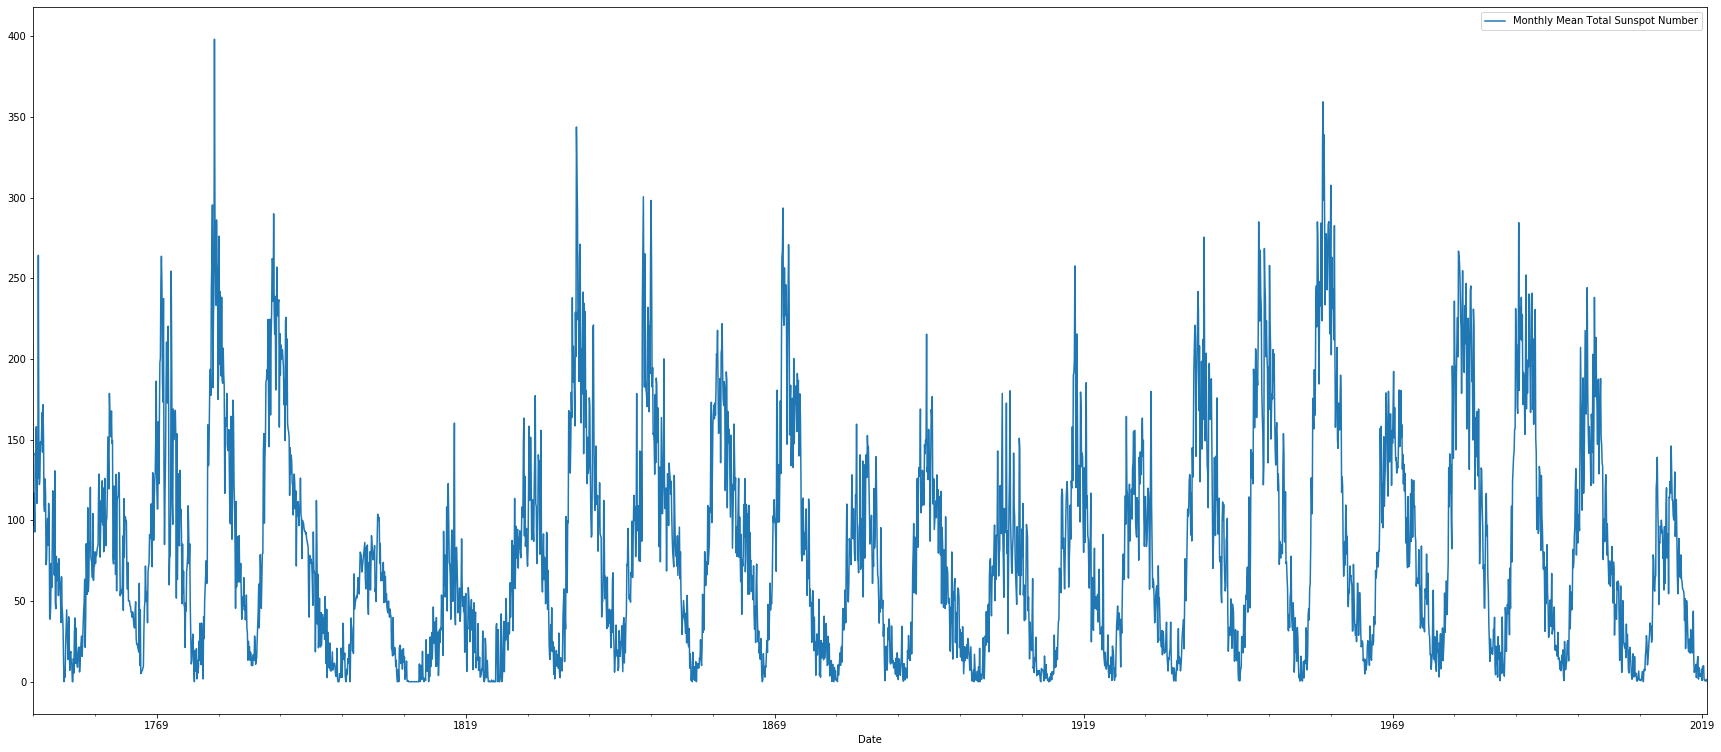

In [69]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 13]

df_plot = get_dataset()

df_plot['Date']= pd.to_datetime(df_plot['Date'])

df_plot.plot(x = 'Date', y = VALUES)

Capture *seasonality, trend, autocorrelation*:

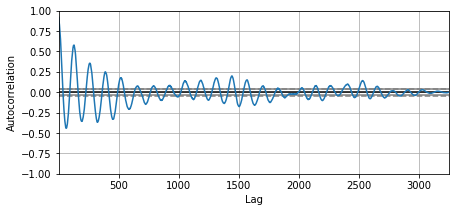

In [73]:
# autocorrelation
from pandas.plotting import autocorrelation_plot
plt.rcParams['figure.figsize'] = [7, 3]

series = get_dataset()
autocorrelation_plot(series[VALUES])
plt.show()

In [0]:
# trend

In [0]:
# seasonality

Short comment what I have found

# **Part 2: dataset splitting**

Use first 70% as train-data, and other 30% as test:

In [0]:
def ts_split(data,percentage=0.7):
    n = int(data.shape[0]*percentage)
    return data[:n], data[n+1:]

train, test = ts_split(df)

# **Part 3: ARIMA as a prediction model**

In [138]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# TODO: describe how 3,0,2 params were choosen
arima = ARIMA(train[VALUES], (0,0,3), dates=train['Date']).fit()

steps = len(test)
predictions = arima.forecast(steps=steps)[0]

# print summary of fit model
print(arima.summary())

# ---TODO---
# RMSE
# RAE
# Charts

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                                      ARMA Model Results                                     
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 2276
Model:                                    ARMA(0, 3)   Log Likelihood              -11211.302
Method:                                      css-mle   S.D. of innovations             33.338
Date:                               Mon, 02 Mar 2020   AIC                          22432.605
Time:                                       19:35:32   BIC                          22461.256
Sample:                                   01-31-1749   HQIC                         22443.056
                                        - 08-31-1938                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                           

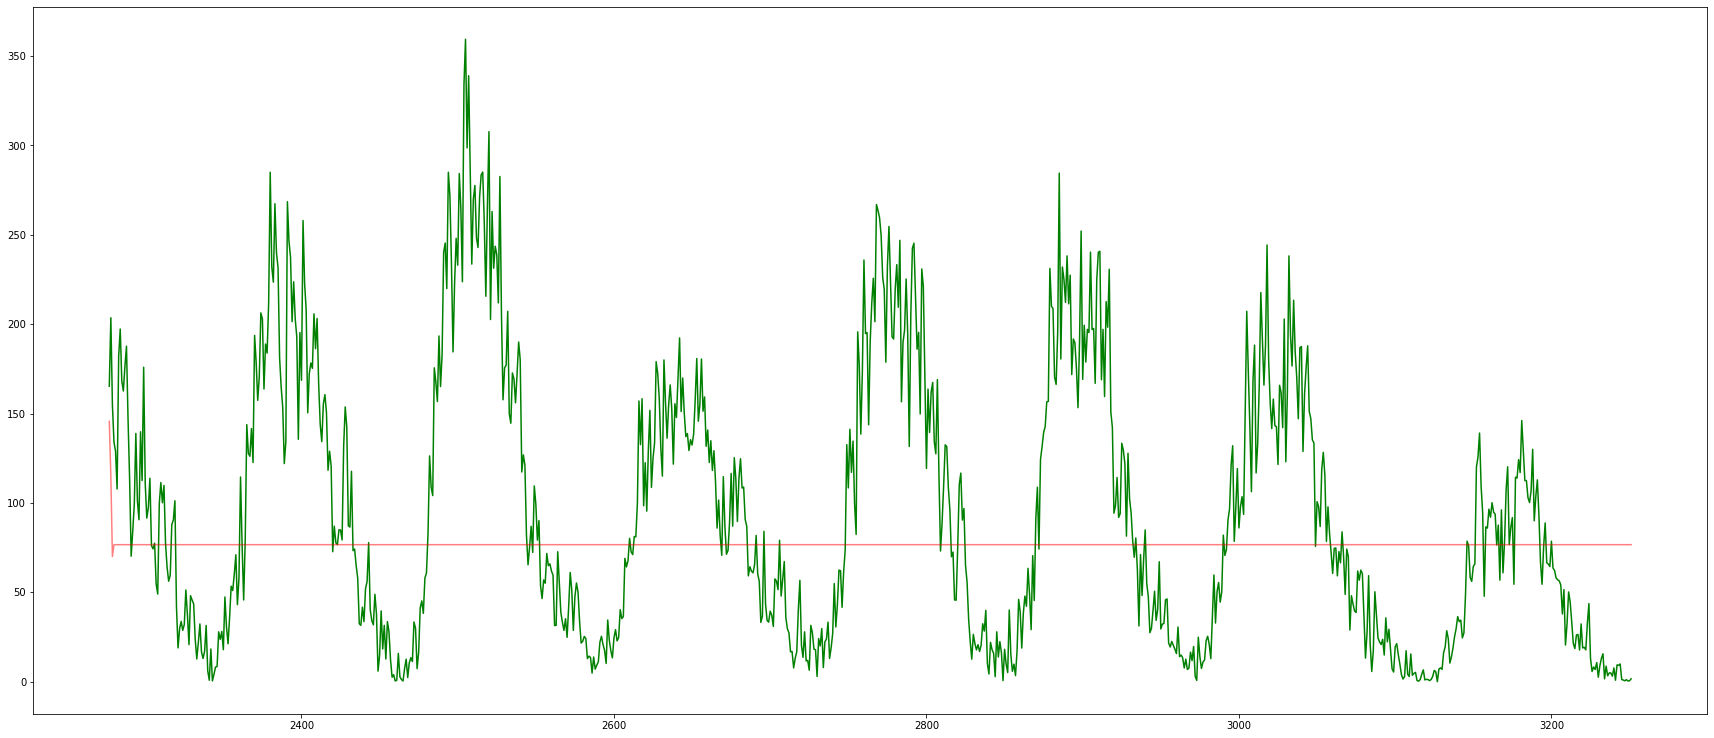

In [139]:
plt.rcParams['figure.figsize'] = [30, 13]

def predictions_to_test(predictions):
    train, test = ts_split(get_dataset())
    test[VALUES] = predictions

    return test

prd = predictions_to_test(predictions)

plt.plot(test[VALUES], color='green')
plt.plot(prd[VALUES], color='red', alpha=0.5)

plt.show()

# **Part 4: RNN as a prediction model**

# **Part 5: final notes**